In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'
os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [2]:
from accelerate.utils import ProjectConfiguration, set_seed

In [3]:
import torch
import random
import numpy as np

def set_seeds(seed):
    set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [4]:
from torchvision import transforms


In [5]:
from diffusers import DDPMPipeline, DDIMPipeline, DDPMScheduler, DDIMScheduler, UNet2DModel

In [6]:
class Args():
    
    model_path = "./saved/5000-0.5/ddpm"
    model_config_name_or_path="config.json"
    
    dataset_name="celeba"

    resolution=64
    center_crop=True
    random_flip=False

    dataloader_num_workers=8
    
    seed=42
    gen_seed=0    
    gen_path = "./saved/5000-0.5/gen"

    train_batch_size=256

    ddpm_num_steps=1000
    ddpm_num_inference_steps=50
    ddpm_beta_schedule='linear'

args=Args()
args.model_config_name_or_path

'config.json'

In [7]:
if True:
    import pandas as pd
    df = pd.DataFrame()
    df['path'] = ['{}/{}.png'.format(args.gen_path, i) for i in range(1000)]
    
    from datasets import DatasetDict, Dataset, Image
    dataset = DatasetDict({
    "train": Dataset.from_dict({
        "img": df['path'].tolist(),
    }).cast_column("img", Image()),})
    dataset = dataset["train"]

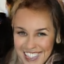

In [8]:
dataset[0]['img']

In [9]:
len(dataset)

1000

In [10]:
from diffusers.utils import randn_tensor

In [12]:
if True:    
    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seeds(args.seed)
    ####    
    print(args.model_config_name_or_path)
    config = UNet2DModel.load_config(args.model_config_name_or_path)
    config['resnet_time_scale_shift'] = 'scale_shift'
        
    model = UNet2DModel.from_config(config) # model 要不要half？
    print(model.dtype)
    ####
    noise_scheduler = DDPMScheduler(num_train_timesteps=args.ddpm_num_steps, beta_schedule=args.ddpm_beta_schedule)
    ddim_noise_scheduler = DDIMScheduler.from_config(noise_scheduler.config)
    ####    
    model_path = '{}/unet/diffusion_pytorch_model.bin'.format(args.model_path)
    print(model_path)
    model.load_state_dict(torch.load(model_path))
    model.cuda()
    model.eval()
    ####
    
    ddim_noise_scheduler.set_timesteps(args.ddpm_num_inference_steps, device='cuda')
    ddim_noise_scheduler_timesteps = ddim_noise_scheduler.timesteps
    print(ddim_noise_scheduler_timesteps)
    
    ####
    dstore_keys = np.memmap('./saved/5000-0.5/gen/gen_latents.npy', 
                                dtype=np.float32, 
                                mode='w+', 
                                shape=(len(dataset), 
                                       args.ddpm_num_inference_steps, 
                                       3, 64, 64)
                               )
    ####
    total=len(dataset)
    for step, i in enumerate(range(0, total, args.train_batch_size)):
        print(i)
        bsz = args.train_batch_size
        if total-i<args.train_batch_size:
            bsz = total-i
        print(bsz)
        print([i+j for j in range(bsz)])
        generator = [torch.Generator('cpu').manual_seed(args.gen_seed*total+i+j) for j in range(bsz)]
        ####
        latents = randn_tensor((len(generator), 3, 64, 64), generator=generator, dtype=torch.float32)
        latents = latents.cuda()
        ####
        for index_t, t in enumerate(ddim_noise_scheduler_timesteps[:]):
            with torch.no_grad():
                noise_pred = model(latents, t).sample
                        
            prev_timestep = t - ddim_noise_scheduler.config.num_train_timesteps // ddim_noise_scheduler.num_inference_steps

            alpha_prod_t = ddim_noise_scheduler.alphas_cumprod[t]
            alpha_prod_t_prev = (
                        ddim_noise_scheduler.alphas_cumprod[prev_timestep]
                        if prev_timestep >= 0
                        else ddim_noise_scheduler.final_alpha_cumprod
                    )
            beta_prod_t = 1 - alpha_prod_t
            ####
            pred_original_sample = (latents - beta_prod_t ** (0.5) * noise_pred) / alpha_prod_t ** (0.5)
            #### 重要
            pred_original_sample = pred_original_sample.clamp(
                -1.0, 1.0
            )
            ####
            pred_epsilon = noise_pred
            pred_sample_direction = (1 - alpha_prod_t_prev) ** (0.5) * pred_epsilon
            prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction
            ####
            dstore_keys[step*args.train_batch_size:step*args.train_batch_size+bsz, index_t] = pred_original_sample.cpu().numpy()
            latents = prev_sample
            ####        
        # break

config.json
torch.float32
./saved/5000-0.5/ddpm/unet/diffusion_pytorch_model.bin
tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0], device='cuda:0')
0
256
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 14

In [13]:
if True:
    set_seeds(42)
    pipeline = DDIMPipeline(
        unet=model,
        scheduler=noise_scheduler,
    ).to('cuda')
    print(pipeline.device)
    print('DDIM!')

cuda:0
DDIM!


In [30]:
i = 0

In [31]:
image = torch.from_numpy(dstore_keys[i])

In [32]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()

In [33]:
images = pipeline.numpy_to_pil(image)

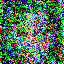

In [34]:
images[0]

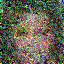

In [35]:
images[5]

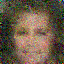

In [36]:
images[10]

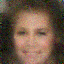

In [37]:
images[15]

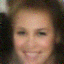

In [38]:
images[20]

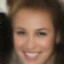

In [39]:
images[25]

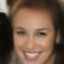

In [40]:
images[30]

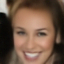

In [41]:
images[35]

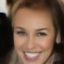

In [42]:
images[40]

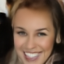

In [43]:
images[45]

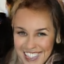

In [44]:
images[-1]

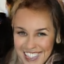

In [45]:
dataset[i]['img']